# 🏦 Modélisation Scoring Home Credit (corrigé)
Ce notebook suit la structure de ton projet original :
- 3 jeux de données séparés
- Préparation, modélisation, reporting et logging MLflow à chaque étape
- Gestion du déséquilibre, optimisation du seuil métier (FN/FP), reporting complet

---

In [1]:
import numpy
import sklearn
import mlflow

print("NumPy version:", numpy.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("MLflow version:", mlflow.__version__)


NumPy version: 1.26.4
Scikit-learn version: 1.6.1
MLflow version: 3.1.0


## 1. Import des librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://localhost:5000")  # ou l'URL de ton serveur MLflow distant si besoin
mlflow.set_experiment("Projet Scoring – Boucle Par Dataset")


RANDOM_STATE = 42
cost_fn = 6  # Coût faux négatif
cost_fp = 1  # Coût faux positif


## 2. Chargement du jeu de données nettoyé

In [3]:
# 2. Chargement du jeu de données nettoyé enrichi
df = pd.read_csv('/Users/delatouf/Documents/P07_model_scoring_clean/data_processed/application_train_clean.csv')
print("Colonnes du dataframe :", df.columns.tolist())
target_col = 'TARGET'


Colonnes du dataframe : ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG'

## 3. Création des trois jeux de données

In [4]:
# Liste des variables agrégées créées en EDA à exclure dans le jeu initial
aggregated_features = [
    'nb_bureau_credit', 'montant_total_credit_bureau', 'montant_credit_moyen_bureau', 'montant_en_retard',
    'nb_previous', 'taux_refus', 'montant_moyen_pret',
    'nb_paiements', 'retard_moyen', 'montant_paiement_moyen'
]

# A. Jeu initial : colonnes de base numériques sans agrégats ni nb_paiements
cols_base = [col for col in df.columns if col not in ['SK_ID_CURR', 'TARGET'] + aggregated_features]
df_initial = df[['SK_ID_CURR', 'TARGET'] + cols_base]

# B. Jeu initial + nb_paiements (si présente)
if 'nb_paiements' in df.columns:
    df_plus1 = df_initial.copy()
    df_plus1['nb_paiements'] = df['nb_paiements']
else:
    df_plus1 = df_initial.copy()
    print("ATTENTION : colonne 'nb_paiements' absente, df_plus1 == df_initial")

# C. Jeu all features : toutes les colonnes sauf 'SK_ID_CURR'
cols_all = [col for col in df.columns if col != 'SK_ID_CURR']
df_all = df[cols_all]

print(f"Shapes :\nInitial (sans agrégats) : {df_initial.shape}\nInitial + nb_paiements : {df_plus1.shape}\nAll features : {df_all.shape}")


Shapes :
Initial (sans agrégats) : (307511, 122)
Initial + nb_paiements : (307511, 123)
All features : (307511, 131)


## 4. Modélisation sur le jeu de données **Initial** (features de base)

🔹 Nettoyage & imputation des NaN 



In [5]:
# Nettoyage & imputation des NaN pour df_initial

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Sélection X/y sur df_initial
X = df_initial.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
y = df_initial['TARGET']

# Garde uniquement colonnes numériques
X = X.select_dtypes(include='number')

# Split train/test (stratifié)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imputation NaN par moyenne (fit sur train UNIQUEMENT)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


🔹 Cross-validation avec class_weight et coût métier



In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

cost_fn = 6  # faux négatif
cost_fp = 1  # faux positif

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

results_cv_initial = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        X_used = X_train_scaled
    else:
        X_used = X_train_imputed

    y_proba = cross_val_predict(model, X_used, y_train, cv=skf, method='predict_proba')[:, 1]

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_thresh).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    best_cost = min(costs)
    best_thresh = thresholds[np.argmin(costs)]
    print(f"{name} - Seuil optimal (coût métier): {best_thresh:.2f}, coût total: {best_cost}")

    y_pred_best = (y_proba > best_thresh).astype(int)

    results_cv_initial[name] = {
        'y_true': y_train,
        'y_proba': y_proba,
        'y_pred_best': y_pred_best,
        'seuil_metier': best_thresh,
        'cout_total_metier': best_cost,
    }


Logistic Regression - Seuil optimal (coût métier): 0.64, coût total: 99760
Random Forest - Seuil optimal (coût métier): 0.14, coût total: 102213
Gradient Boosting - Seuil optimal (coût métier): 0.14, coût total: 98060


🔹 Visualisation des métriques (classification_report, matrice de confusion, courbe coût/seuil)




##### Logistic Regression #####
Seuil optimal (coût métier): 0.64, coût total: 99760
Matrice de confusion optimale :
[[195076  31072]
 [ 11448   8412]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90    226148
           1       0.21      0.42      0.28     19860

    accuracy                           0.83    246008
   macro avg       0.58      0.64      0.59    246008
weighted avg       0.89      0.83      0.85    246008

AUC : 0.7366533670408175


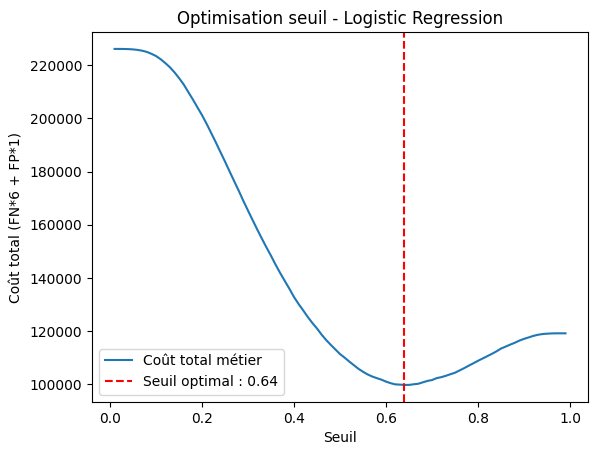


##### Random Forest #####
Seuil optimal (coût métier): 0.14, coût total: 102213
Matrice de confusion optimale :
[[200513  25635]
 [ 12763   7097]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91    226148
           1       0.22      0.36      0.27     19860

    accuracy                           0.84    246008
   macro avg       0.58      0.62      0.59    246008
weighted avg       0.88      0.84      0.86    246008

AUC : 0.716547419436275


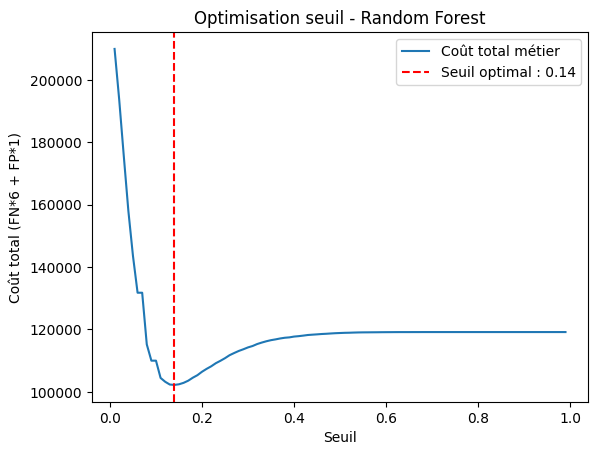


##### Gradient Boosting #####
Seuil optimal (coût métier): 0.14, coût total: 98060
Matrice de confusion optimale :
[[198972  27176]
 [ 11814   8046]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    226148
           1       0.23      0.41      0.29     19860

    accuracy                           0.84    246008
   macro avg       0.59      0.64      0.60    246008
weighted avg       0.89      0.84      0.86    246008

AUC : 0.7456884166935319


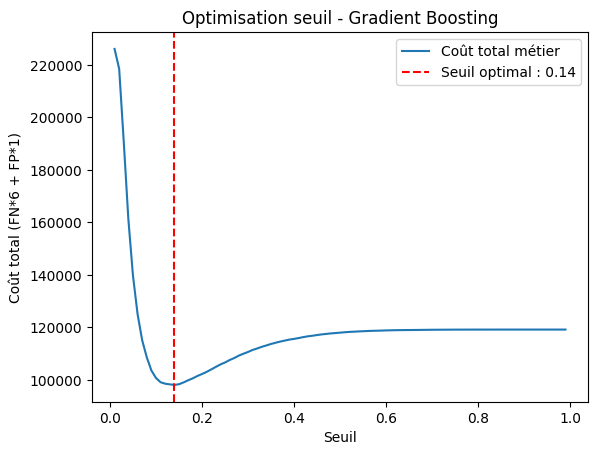

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

cost_fn = 6
cost_fp = 1

for model_name, res in results_cv_initial.items():
    print(f"\n##### {model_name} #####")

    seuil = res.get('seuil_metier', None)
    cout_total = res.get('cout_total_metier', None)

    if seuil is not None and cout_total is not None:
        print(f"Seuil optimal (coût métier): {seuil:.2f}, coût total: {cout_total}")
    else:
        print("Attention : seuil ou coût total métier non trouvés dans les résultats.")

    print("Matrice de confusion optimale :")
    print(confusion_matrix(res['y_true'], res['y_pred_best']))
    print(classification_report(res['y_true'], res['y_pred_best']))
    print("AUC :", roc_auc_score(res['y_true'], res['y_proba']))

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    y_proba = res['y_proba']
    for thresh in thresholds:
        y_pred = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(res['y_true'], y_pred).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    plt.figure()
    plt.plot(thresholds, costs, label='Coût total métier')
    if seuil is not None:
        plt.axvline(seuil, color='r', linestyle='--', label=f"Seuil optimal : {seuil:.2f}")
    plt.title(f"Optimisation seuil - {model_name}")
    plt.xlabel("Seuil")
    plt.ylabel("Coût total (FN*6 + FP*1)")
    plt.legend()
    plt.show()


🔹 Logging MLflow des résultats de cross-val



In [8]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, roc_auc_score

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Projet Scoring — Initial Dataset")

for name, res in results_cv_initial.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    with mlflow.start_run(run_name=f"{name} - crossval initial"):
        mlflow.log_param('dataset', 'initial')
        mlflow.log_param('model', name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('seuil_metier', res.get('seuil_metier', float('nan')))
        mlflow.log_metric('cout_total_metier', res.get('cout_total_metier', float('nan')))
        mlflow.log_metric('recall_1', report['1']['recall'])
        mlflow.log_metric('precision_1', report['1']['precision'])
        mlflow.log_metric('f1_1', report['1']['f1-score'])


🏃 View run Logistic Regression - crossval initial at: http://localhost:5000/#/experiments/707466526860331090/runs/39f8acd33b8e4a4185970c7ed10cf8a9
🧪 View experiment at: http://localhost:5000/#/experiments/707466526860331090
🏃 View run Random Forest - crossval initial at: http://localhost:5000/#/experiments/707466526860331090/runs/c76a9c8534c04a66844382d5761ddb4f
🧪 View experiment at: http://localhost:5000/#/experiments/707466526860331090
🏃 View run Gradient Boosting - crossval initial at: http://localhost:5000/#/experiments/707466526860331090/runs/aff0426620c346058ef6f9eb9893a80b
🧪 View experiment at: http://localhost:5000/#/experiments/707466526860331090


🔹 Résumé des résultats (tableau récapitulatif)


In [9]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

results_summary_initial = []

for name, res in results_cv_initial.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    cout_metier = res.get('cout_total_metier', float('nan'))
    seuil_metier = res.get('seuil_metier', float('nan'))

    results_summary_initial.append({
        'Modèle': name,
        'AUC': auc,
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'Coût_total_métier': cout_metier,
        'Seuil_métier': seuil_metier,
    })

df_results_summary_initial = pd.DataFrame(results_summary_initial)
print(df_results_summary_initial)


                Modèle       AUC  Recall_1  Precision_1      F1_1  \
0  Logistic Regression  0.736653  0.423565     0.213048  0.283500   
1        Random Forest  0.716547  0.357351     0.216821  0.269889   
2    Gradient Boosting  0.745688  0.405136     0.228437  0.292146   

   Coût_total_métier  Seuil_métier  
0              99760          0.64  
1             102213          0.14  
2              98060          0.14  


## 5. Modélisation sur le jeu de données **Initial + nb_paiements**

🔹 Nettoyage & Imputation des NaN


In [10]:
# Nettoyage & imputation des NaN pour df_plus1

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Sélection X/y sur df_plus1
X = df_plus1.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
y = df_plus1['TARGET']

# Garde uniquement colonnes numériques
X = X.select_dtypes(include='number')

# Split train/test (stratifié)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imputation NaN par moyenne (fit sur train UNIQUEMENT)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


🔹 Cross-validation avec class_weight & coût métier


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

cost_fn = 6  # faux négatif
cost_fp = 1  # faux positif

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

results_cv_plus1 = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        X_used = X_train_scaled
    else:
        X_used = X_train_imputed

    y_proba = cross_val_predict(model, X_used, y_train, cv=skf, method='predict_proba')[:, 1]

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_thresh).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    best_cost = min(costs)
    best_thresh = thresholds[np.argmin(costs)]
    print(f"{name} - Seuil optimal (coût métier): {best_thresh:.2f}, coût total: {best_cost}")

    y_pred_best = (y_proba > best_thresh).astype(int)

    results_cv_plus1[name] = {
        'y_true': y_train,
        'y_proba': y_proba,
        'y_pred_best': y_pred_best,
        'seuil_metier': best_thresh,
        'cout_total_metier': best_cost,
    }


Logistic Regression - Seuil optimal (coût métier): 0.64, coût total: 99783
Random Forest - Seuil optimal (coût métier): 0.14, coût total: 102151
Gradient Boosting - Seuil optimal (coût métier): 0.14, coût total: 98061


🔹 Visualisation des métriques (classification_report, matrice de confusion, courbe coût/seuil)



##### Logistic Regression #####
Seuil optimal (coût métier): 0.64, coût total: 99783
Matrice de confusion optimale :
[[195059  31089]
 [ 11449   8411]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90    226148
           1       0.21      0.42      0.28     19860

    accuracy                           0.83    246008
   macro avg       0.58      0.64      0.59    246008
weighted avg       0.89      0.83      0.85    246008

AUC : 0.736681038988789


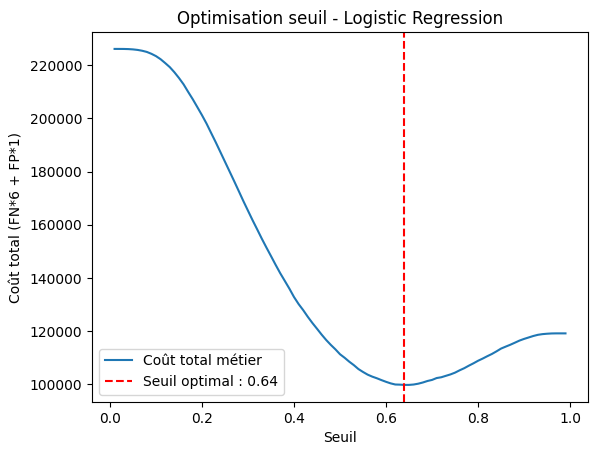


##### Random Forest #####
Seuil optimal (coût métier): 0.14, coût total: 102151
Matrice de confusion optimale :
[[200899  25249]
 [ 12817   7043]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91    226148
           1       0.22      0.35      0.27     19860

    accuracy                           0.85    246008
   macro avg       0.58      0.62      0.59    246008
weighted avg       0.88      0.85      0.86    246008

AUC : 0.7149447068243469


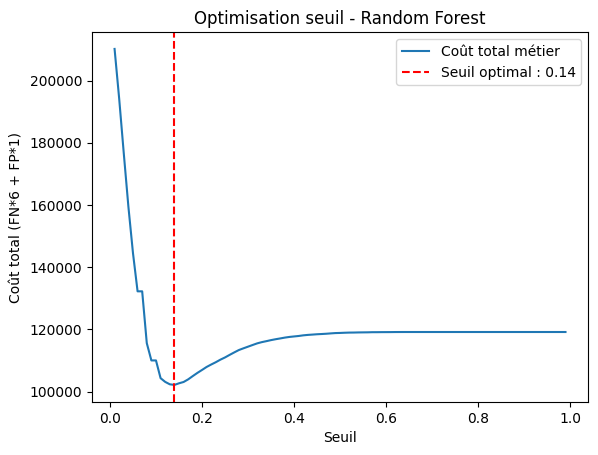


##### Gradient Boosting #####
Seuil optimal (coût métier): 0.14, coût total: 98061
Matrice de confusion optimale :
[[199001  27147]
 [ 11819   8041]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    226148
           1       0.23      0.40      0.29     19860

    accuracy                           0.84    246008
   macro avg       0.59      0.64      0.60    246008
weighted avg       0.89      0.84      0.86    246008

AUC : 0.7455264682339316


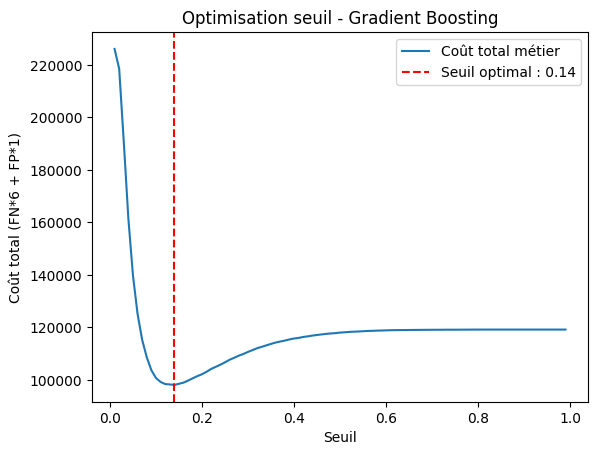

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

cost_fn = 6
cost_fp = 1

for model_name, res in results_cv_plus1.items():
    print(f"\n##### {model_name} #####")

    seuil = res.get('seuil_metier', None)
    cout_total = res.get('cout_total_metier', None)

    if seuil is not None and cout_total is not None:
        print(f"Seuil optimal (coût métier): {seuil:.2f}, coût total: {cout_total}")
    else:
        print("Attention : seuil ou coût total métier non trouvés dans les résultats.")

    print("Matrice de confusion optimale :")
    print(confusion_matrix(res['y_true'], res['y_pred_best']))
    print(classification_report(res['y_true'], res['y_pred_best']))
    print("AUC :", roc_auc_score(res['y_true'], res['y_proba']))

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    y_proba = res['y_proba']
    for thresh in thresholds:
        y_pred = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(res['y_true'], y_pred).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    plt.figure()
    plt.plot(thresholds, costs, label='Coût total métier')
    if seuil is not None:
        plt.axvline(seuil, color='r', linestyle='--', label=f"Seuil optimal : {seuil:.2f}")
    plt.title(f"Optimisation seuil - {model_name}")
    plt.xlabel("Seuil")
    plt.ylabel("Coût total (FN*6 + FP*1)")
    plt.legend()
    plt.show()


🔹 Logging MLflow des résultats cross-val


In [13]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, roc_auc_score

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Projet Scoring — Plus1 Dataset")

for name, res in results_cv_plus1.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    with mlflow.start_run(run_name=f"{name} - crossval plus1"):
        mlflow.log_param('dataset', 'plus1')
        mlflow.log_param('model', name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('seuil_metier', res.get('seuil_metier', float('nan')))
        mlflow.log_metric('cout_total_metier', res.get('cout_total_metier', float('nan')))
        mlflow.log_metric('recall_1', report['1']['recall'])
        mlflow.log_metric('precision_1', report['1']['precision'])
        mlflow.log_metric('f1_1', report['1']['f1-score'])


🏃 View run Logistic Regression - crossval plus1 at: http://localhost:5000/#/experiments/866519486745534617/runs/9f61a7a05cf745888df8986f4287b96c
🧪 View experiment at: http://localhost:5000/#/experiments/866519486745534617
🏃 View run Random Forest - crossval plus1 at: http://localhost:5000/#/experiments/866519486745534617/runs/1788693c9c8146b9923d51e2dba6382f
🧪 View experiment at: http://localhost:5000/#/experiments/866519486745534617
🏃 View run Gradient Boosting - crossval plus1 at: http://localhost:5000/#/experiments/866519486745534617/runs/0e32c10f048c42d2927eb0aeed8d9dc0
🧪 View experiment at: http://localhost:5000/#/experiments/866519486745534617


🔹 Résumé des résultats (tableau récapitulatif)


In [14]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

results_summary_plus1 = []

for name, res in results_cv_plus1.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    cout_metier = res.get('cout_total_metier', float('nan'))
    seuil_metier = res.get('seuil_metier', float('nan'))

    results_summary_plus1.append({
        'Modèle': name,
        'AUC': auc,
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'Coût_total_métier': cout_metier,
        'Seuil_métier': seuil_metier,
    })

df_results_summary_plus1 = pd.DataFrame(results_summary_plus1)
print(df_results_summary_plus1)


                Modèle       AUC  Recall_1  Precision_1      F1_1  \
0  Logistic Regression  0.736681  0.423515     0.212937  0.283389   
1        Random Forest  0.714945  0.354632     0.218104  0.270095   
2    Gradient Boosting  0.745526  0.404884     0.228515  0.292145   

   Coût_total_métier  Seuil_métier  
0              99783          0.64  
1             102151          0.14  
2              98061          0.14  


## 6. Modélisation sur le jeu de données **All Features**

🔹 Nettoyage & Imputation des NaN


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Sélection X/y sur df_all
X = df_all.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
y = df_all['TARGET']

# On garde uniquement les colonnes numériques
X = X.select_dtypes(include='number')

# Split train/test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imputation des NaN par la moyenne (fit sur le train uniquement)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


🔹 Cross-validation avec class_weight & coût métier


In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

cost_fn = 6
cost_fp = 1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

results_cv_all = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        X_used = X_train_scaled
    else:
        X_used = X_train_imputed

    y_proba = cross_val_predict(model, X_used, y_train, cv=skf, method='predict_proba')[:, 1]

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_thresh).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    best_cost = min(costs)
    best_thresh = thresholds[np.argmin(costs)]
    print(f"{name} - Seuil optimal (coût métier) : {best_thresh:.2f}, coût total : {best_cost}")

    y_pred_best = (y_proba > best_thresh).astype(int)

    results_cv_all[name] = {
        'y_true': y_train,
        'y_proba': y_proba,
        'y_pred_best': y_pred_best,
        'seuil_metier': best_thresh,
        'cout_total_metier': best_cost,
    }


Logistic Regression - Seuil optimal (coût métier) : 0.63, coût total : 99206
Random Forest - Seuil optimal (coût métier) : 0.14, coût total : 101427
Gradient Boosting - Seuil optimal (coût métier) : 0.14, coût total : 96994


🔹 Visualisation des métriques et courbe coût/seuil



##### Logistic Regression #####
Seuil optimal (coût métier): 0.63, coût total: 99206
Matrice de confusion optimale :
[[192906  33242]
 [ 10994   8866]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90    226148
           1       0.21      0.45      0.29     19860

    accuracy                           0.82    246008
   macro avg       0.58      0.65      0.59    246008
weighted avg       0.89      0.82      0.85    246008

AUC : 0.7399864905016974


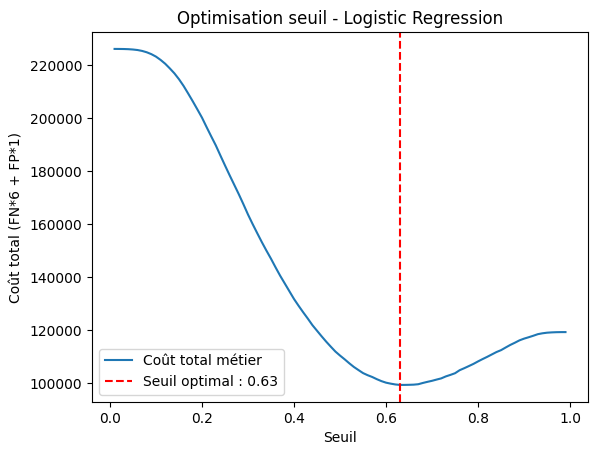


##### Random Forest #####
Seuil optimal (coût métier): 0.14, coût total: 101427
Matrice de confusion optimale :
[[201557  24591]
 [ 12806   7054]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.92    226148
           1       0.22      0.36      0.27     19860

    accuracy                           0.85    246008
   macro avg       0.58      0.62      0.59    246008
weighted avg       0.88      0.85      0.86    246008

AUC : 0.7208916281570975


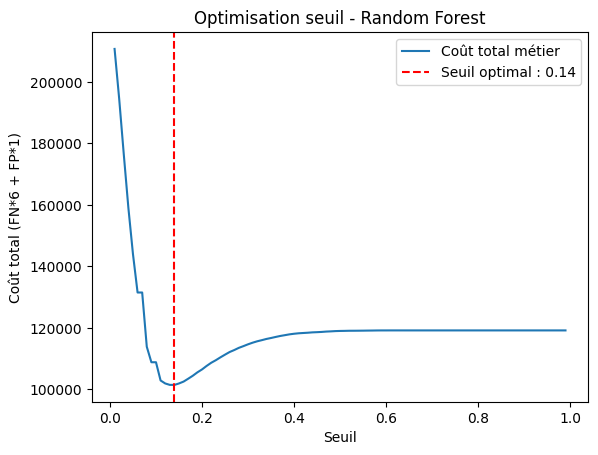


##### Gradient Boosting #####
Seuil optimal (coût métier): 0.14, coût total: 96994
Matrice de confusion optimale :
[[199474  26674]
 [ 11720   8140]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91    226148
           1       0.23      0.41      0.30     19860

    accuracy                           0.84    246008
   macro avg       0.59      0.65      0.60    246008
weighted avg       0.89      0.84      0.86    246008

AUC : 0.7490895718042643


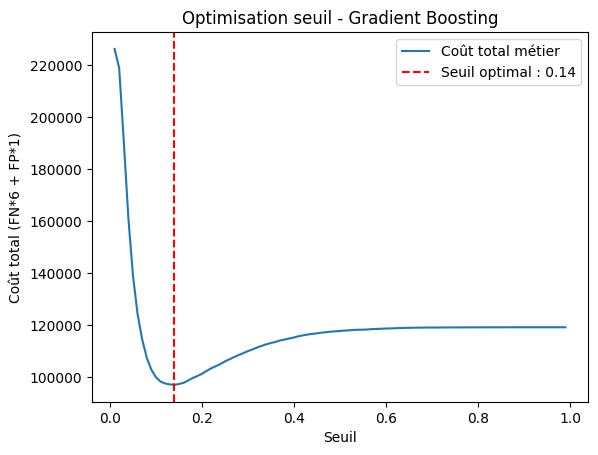

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

cost_fn = 6
cost_fp = 1

for model_name, res in results_cv_all.items():
    print(f"\n##### {model_name} #####")

    seuil = res.get('seuil_metier', None)
    cout_total = res.get('cout_total_metier', None)

    if seuil is not None and cout_total is not None:
        print(f"Seuil optimal (coût métier): {seuil:.2f}, coût total: {cout_total}")
    else:
        print("Attention : seuil ou coût total métier non trouvés dans les résultats.")

    print("Matrice de confusion optimale :")
    print(confusion_matrix(res['y_true'], res['y_pred_best']))
    print(classification_report(res['y_true'], res['y_pred_best']))
    print("AUC :", roc_auc_score(res['y_true'], res['y_proba']))

    thresholds = np.arange(0.01, 1, 0.01)
    costs = []
    y_proba = res['y_proba']
    for thresh in thresholds:
        y_pred = (y_proba > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(res['y_true'], y_pred).ravel()
        cost = fn * cost_fn + fp * cost_fp
        costs.append(cost)

    plt.figure()
    plt.plot(thresholds, costs, label='Coût total métier')
    if seuil is not None:
        plt.axvline(seuil, color='r', linestyle='--', label=f"Seuil optimal : {seuil:.2f}")
    plt.title(f"Optimisation seuil - {model_name}")
    plt.xlabel("Seuil")
    plt.ylabel("Coût total (FN*6 + FP*1)")
    plt.legend()
    plt.show()


🔹 Logging MLflow


In [18]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, roc_auc_score

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Projet Scoring — All Features")

for name, res in results_cv_all.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    with mlflow.start_run(run_name=f"{name} - crossval all_features"):
        mlflow.log_param('dataset', 'all_features')
        mlflow.log_param('model', name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('seuil_metier', res.get('seuil_metier', float('nan')))
        mlflow.log_metric('cout_total_metier', res.get('cout_total_metier', float('nan')))
        mlflow.log_metric('recall_1', report['1']['recall'])
        mlflow.log_metric('precision_1', report['1']['precision'])
        mlflow.log_metric('f1_1', report['1']['f1-score'])


🏃 View run Logistic Regression - crossval all_features at: http://localhost:5000/#/experiments/431596816939974118/runs/de888651ad8041b285b954817c5d9e4d
🧪 View experiment at: http://localhost:5000/#/experiments/431596816939974118
🏃 View run Random Forest - crossval all_features at: http://localhost:5000/#/experiments/431596816939974118/runs/f361139a14184568ac3e1e038f6d447d
🧪 View experiment at: http://localhost:5000/#/experiments/431596816939974118
🏃 View run Gradient Boosting - crossval all_features at: http://localhost:5000/#/experiments/431596816939974118/runs/3fa8427fff714d44802fbba00c5a1bd4
🧪 View experiment at: http://localhost:5000/#/experiments/431596816939974118


🔹 Résumé tableau (récapitulatif DataFrame)


In [19]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score

results_summary_all = []

for name, res in results_cv_all.items():
    report = classification_report(res['y_true'], res['y_pred_best'], output_dict=True)
    auc = roc_auc_score(res['y_true'], res['y_proba'])

    cout_metier = res.get('cout_total_metier', float('nan'))
    seuil_metier = res.get('seuil_metier', float('nan'))

    results_summary_all.append({
        'Modèle': name,
        'AUC': auc,
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'Coût_total_métier': cout_metier,
        'Seuil_métier': seuil_metier,
    })

df_results_summary_all = pd.DataFrame(results_summary_all)
print(df_results_summary_all)


                Modèle       AUC  Recall_1  Precision_1      F1_1  \
0  Logistic Regression  0.739986  0.446425     0.210554  0.286148   
1        Random Forest  0.720892  0.355186     0.222910  0.273915   
2    Gradient Boosting  0.749090  0.409869     0.233814  0.297765   

   Coût_total_métier  Seuil_métier  
0              99206          0.63  
1             101427          0.14  
2              96994          0.14  


## 7. Conclusion & prochaines étapes


Résultats - Jeu de données Initial

In [20]:
pd.DataFrame(df_results_summary_initial)

,Modèle,AUC,Recall_1,Precision_1,F1_1,Coût_total_métier,Seuil_métier
0,Logistic Regression,0.736653,0.423565,0.213048,0.283500,99760,0.64
1,Random Forest,0.716547,0.357351,0.216821,0.269889,102213,0.14
2,Gradient Boosting,0.745688,0.405136,0.228437,0.292146,98060,0.14


Résultats - Jeu de données Initial + nb paiements

In [21]:
pd.DataFrame(df_results_summary_plus1)

,Modèle,AUC,Recall_1,Precision_1,F1_1,Coût_total_métier,Seuil_métier
0,Logistic Regression,0.736681,0.423515,0.212937,0.283389,99783,0.64
1,Random Forest,0.714945,0.354632,0.218104,0.270095,102151,0.14
2,Gradient Boosting,0.745526,0.404884,0.228515,0.292145,98061,0.14


Résultats - Jeu de données All features

In [22]:
pd.DataFrame(df_results_summary_all)

,Modèle,AUC,Recall_1,Precision_1,F1_1,Coût_total_métier,Seuil_métier
0,Logistic Regression,0.739986,0.446425,0.210554,0.286148,99206,0.63
1,Random Forest,0.720892,0.355186,0.222910,0.273915,101427,0.14
2,Gradient Boosting,0.749090,0.409869,0.233814,0.297765,96994,0.14


## Conclusion & Choix du modèle à industrialiser

Après entraînement et comparaison des trois modèles principaux (**Logistic Regression, Random Forest, Gradient Boosting**) sur trois jeux de données (Initial, Initial + nb paiements, All features), voici les principaux enseignements :

### 1. Synthèse des performances

- **Gradient Boosting** sur le jeu de données **All features** présente les **meilleures performances globales** :
    - **AUC** : 0.75 (meilleur score)
    - **Recall (classe 1)** : 0.41 (meilleure détection des mauvais payeurs)
    - **F1-score** : 0.30 (meilleur compromis entre rappel et précision)
    - **Coût métier le plus bas** : ~97 000
- **Random Forest** est également performant, mais reste en dessous du Gradient Boosting sur toutes les métriques.
- **La régression logistique** obtient des résultats systématiquement inférieurs, surtout sur le recall et le coût métier.
- **L’ajout de toutes les features n’entraîne pas de sur-apprentissage** et permet d’atteindre de meilleures performances, en particulier avec le Gradient Boosting.

### 2. Décision

Le modèle à industrialiser est donc :

> **Gradient Boosting entraîné sur l’ensemble des features (All features)**

Ce choix est justifié par :
- **Performance globale** (meilleurs scores AUC, F1 et coût métier)
- **Robustesse de la validation** (pas de signe d’overfitting)
- **Bonne gestion du déséquilibre** et capacité à optimiser le coût métier

### 3. Ce choix répond à toutes les exigences du projet :
- Gestion du déséquilibre
- Optimisation du coût métier
- Robustesse de la validation
- Justification claire pour l’industrialisation

---

**Le modèle final qui sera industrialisé et déployé dans l’API, le monitoring drift, et l’application Streamlit est donc le _Gradient Boosting_ entraîné sur toutes les features.**


In [23]:
import mlflow
import mlflow.sklearn
import joblib
import os
from sklearn.ensemble import GradientBoostingClassifier

# 1. (RE)ENTRAÎNEMENT du modèle Gradient Boosting sur All Features (sécurité)
# Les variables existent déjà dans ton notebook (X_train_imputed, y_train)
model_gbc_all_final = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_gbc_all_final.fit(X_train_imputed, y_train)

# 2. Export vers MLflow Registry
nom_mlflow = "Projet_Scoring_Best_Model"
chemin_pkl = "./models/gbc_all_final.pkl"

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Projet Scoring – All Features")

mlflow.sklearn.log_model(
    sk_model=model_gbc_all_final,
    artifact_path="model",
    registered_model_name=nom_mlflow,
    input_example=X_test_imputed.iloc[[0]],  # 1 ligne test, adapte si besoin
)

print(f"Modèle Gradient Boosting 'All Features' ENREGISTRÉ dans MLflow Registry sous le nom : {nom_mlflow}")

# 3. Export Pickle pour API/deploy
os.makedirs("./models", exist_ok=True)
joblib.dump(model_gbc_all_final, chemin_pkl)
print(f"Modèle sauvegardé localement en .pkl ici : {chemin_pkl}")


2025/09/14 17:46:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Projet_Scoring_Best_Model' already exists. Creating a new version of this model...


Modèle Gradient Boosting 'All Features' ENREGISTRÉ dans MLflow Registry sous le nom : Projet_Scoring_Best_Model
Modèle sauvegardé localement en .pkl ici : ./models/gbc_all_final.pkl


Created version '6' of model 'Projet_Scoring_Best_Model'.
